In [50]:
import pandas as pd
df = pd.read_csv('./construction_project_dataset.csv')   # adjust the filename after unzip
df.head(), df.info(), df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   50000 non-null  object 
 1   temperature                 50000 non-null  float64
 2   humidity                    50000 non-null  float64
 3   vibration_level             50000 non-null  float64
 4   material_usage              50000 non-null  float64
 5   machinery_status            50000 non-null  int64  
 6   worker_count                50000 non-null  int64  
 7   energy_consumption          50000 non-null  float64
 8   task_progress               50000 non-null  float64
 9   cost_deviation              50000 non-null  float64
 10  time_deviation              50000 non-null  float64
 11  safety_incidents            50000 non-null  int64  
 12  equipment_utilization_rate  50000 non-null  float64
 13  material_shortage_alert     500

(             timestamp  temperature   humidity  vibration_level  material_usage  machinery_status  worker_count  energy_consumption  \
 0  2023-01-01 00:00:00    24.363503  70.834195        29.038952      162.290510                 0            10          394.617852   
 1  2023-01-01 00:01:00    38.767858  49.671023        26.348582      627.127074                 1            16          334.086917   
 2  2023-01-01 00:02:00    33.299849  31.727937        17.551847      818.981866                 0            17           70.030254   
 3  2023-01-01 00:03:00    29.966462  64.198507        24.660633      788.025785                 1            19          275.610928   
 4  2023-01-01 00:04:00    18.900466  45.120688        18.254832      853.656587                 0            32          377.220779   
 
    task_progress  cost_deviation  time_deviation  safety_incidents  equipment_utilization_rate  material_shortage_alert  risk_score  \
 0       0.025050     2707.711346       -4.645

In [51]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

pd.options.display.width = 140
pd.options.display.max_columns = 60

CSV_PATH = "./construction_project_dataset.csv"
OUT_DIR = "./anomaly_out"
os.makedirs(OUT_DIR, exist_ok=True)

# Detector hyperparams
RESAMPLE_RULE = "H"   # resample minute data to hourly
ROLLING_WIN  = 24     # 24 hours rolling window
CONTAM       = 0.03   # ~3% anomaly rate
RANDOM_STATE = 42
EPS          = 1e-6


In [52]:
df = pd.read_csv(CSV_PATH)

print(df.shape)
df.head()


(50000, 19)


,timestamp,temperature,humidity,vibration_level,material_usage,machinery_status,worker_count,energy_consumption,task_progress,cost_deviation,time_deviation,safety_incidents,equipment_utilization_rate,material_shortage_alert,risk_score,simulation_deviation,update_frequency,optimization_suggestion,performance_score
0,2023-01-01 00:00:00,24.363503,70.834195,29.038952,162.290510,0,10,394.617852,0.025050,2707.711346,-4.645563,2,84.481661,0,23.181975,0.768037,10,Optimize Material Usage,Excellent
1,2023-01-01 00:01:00,38.767858,49.671023,26.348582,627.127074,1,16,334.086917,0.062199,1866.881543,-0.673013,0,85.115701,0,64.242931,6.958721,15,Optimize Material Usage,Excellent
2,2023-01-01 00:02:00,33.299849,31.727937,17.551847,818.981866,0,17,70.030254,0.141820,-2913.483082,-5.667880,0,82.006109,0,97.199452,8.980785,5,Reallocate Workers,Excellent
3,2023-01-01 00:03:00,29.966462,64.198507,24.660633,788.025785,1,19,275.610928,0.169591,-2778.924736,-8.373158,0,93.410108,1,58.238809,3.295682,5,Reallocate Workers,Excellent
4,2023-01-01 00:04:00,18.900466,45.120688,18.254832,853.656587,0,32,377.220779,0.185736,-2332.484349,-3.455996,0,52.694279,0,19.748945,0.223819,15,Optimize Material Usage,Excellent


In [53]:
df = df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df[["timestamp","worker_count","energy_consumption","material_usage","task_progress","equipment_utilization_rate"]].head()


,timestamp,worker_count,energy_consumption,material_usage,task_progress,equipment_utilization_rate
0,2023-01-01 00:00:00,10,394.617852,162.290510,0.025050,84.481661
1,2023-01-01 00:01:00,16,334.086917,627.127074,0.062199,85.115701
2,2023-01-01 00:02:00,17,70.030254,818.981866,0.141820,82.006109
3,2023-01-01 00:03:00,19,275.610928,788.025785,0.169591,93.410108
4,2023-01-01 00:04:00,32,377.220779,853.656587,0.185736,52.694279


In [54]:
def resample_hourly(raw: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate minute-level noise to hourly.
    Sums for flow-like metrics; means for levels.
    """
    g = raw.set_index("timestamp").resample(RESAMPLE_RULE).agg({
        "task_progress": "sum",
        "material_usage": "sum",
        "energy_consumption": "sum",
        "worker_count": "mean",
        "equipment_utilization_rate": "mean",
    })
    g = g.dropna(how="any").reset_index()
    return g

hourly = resample_hourly(df)
hourly.head()


/tmp/ipython-input-2233773677.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g = raw.set_index("timestamp").resample(RESAMPLE_RULE).agg({


,timestamp,task_progress,material_usage,energy_consumption,worker_count,equipment_utilization_rate
0,2023-01-01 00:00:00,96.996010,32647.071385,17654.044019,27.883333,75.352137
1,2023-01-01 01:00:00,298.499828,33350.713806,15515.442979,29.066667,75.182335
2,2023-01-01 02:00:00,487.590254,31108.987792,18500.545631,26.866667,74.825789
3,2023-01-01 03:00:00,692.000209,33269.221533,16126.253068,25.183333,76.202455
4,2023-01-01 04:00:00,885.921403,32775.865399,16815.549538,26.016667,73.120126


In [55]:
def make_features(tab: pd.DataFrame, win: int = ROLLING_WIN) -> pd.DataFrame:
    X = tab.copy()

    # Ratio features capture efficiency
    X["progress_per_worker"] = X["task_progress"] / (X["worker_count"] + EPS)
    X["progress_per_kwh"]    = X["task_progress"] / (X["energy_consumption"] + EPS)
    X["material_efficiency"] = X["task_progress"] / (X["material_usage"] + EPS)

    # Rolling mean and z-scores; pct change for momentum
    cols = [
        "task_progress","worker_count","energy_consumption",
        "material_usage","equipment_utilization_rate",
        "progress_per_worker","progress_per_kwh","material_efficiency"
    ]
    for c in cols:
        roll_mean = X[c].rolling(win, min_periods=max(2, win//4)).mean()
        roll_std  = X[c].rolling(win, min_periods=max(2, win//4)).std()
        X[f"{c}_z"]      = (X[c] - roll_mean) / (roll_std + EPS)
        X[f"{c}_pctchg"] = X[c].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)

    X = X.dropna().reset_index(drop=True)
    return X

feats = make_features(hourly, win=ROLLING_WIN)
print(feats.shape)
feats.head()


(829, 25)


,timestamp,task_progress,material_usage,energy_consumption,worker_count,equipment_utilization_rate,progress_per_worker,progress_per_kwh,material_efficiency,task_progress_z,task_progress_pctchg,worker_count_z,worker_count_pctchg,energy_consumption_z,energy_consumption_pctchg,material_usage_z,material_usage_pctchg,equipment_utilization_rate_z,equipment_utilization_rate_pctchg,progress_per_worker_z,progress_per_worker_pctchg,progress_per_kwh_z,progress_per_kwh_pctchg,material_efficiency_z,material_efficiency_pctchg
0,2023-01-01 05:00:00,1077.131446,29269.638420,16389.658176,27.583333,74.444535,39.050081,0.065720,0.036800,1.327846,0.215832,0.348513,0.060218,-0.409112,-0.025327,-1.758979,-0.106976,-0.396424,0.018113,1.223842,0.146776,1.352666,0.247426,1.474448,0.361477
1,2023-01-01 06:00:00,1287.974156,31820.370799,17260.069562,29.666667,77.113717,43.414858,0.074622,0.040476,1.403150,0.195745,1.379346,0.075529,0.364257,0.053107,-0.147050,0.087146,1.521102,0.035855,1.218447,0.111774,1.330481,0.135444,1.342440,0.099893
2,2023-01-01 07:00:00,1486.142811,32084.169114,15063.354983,26.883333,74.653548,55.281194,0.098659,0.046320,1.437107,0.153861,-0.342337,-0.093820,-1.414868,-0.127271,0.032192,0.008290,-0.384123,-0.031903,1.506485,0.273324,1.625876,0.322130,1.382040,0.144374
3,2023-01-01 08:00:00,1690.962557,30686.720497,17257.885734,27.483333,75.181260,61.526834,0.097982,0.055104,1.472898,0.137820,0.057082,0.022319,0.488576,0.145687,-0.898331,-0.043556,0.055289,0.007069,1.474959,0.112979,1.323325,-0.006867,1.520728,0.189635
4,2023-01-01 09:00:00,1893.530022,35946.535417,17304.614369,28.900000,78.742309,65.520068,0.109423,0.052676,1.497684,0.119794,0.963456,0.051546,0.499895,0.002708,2.027828,0.171404,2.095919,0.047366,1.395923,0.064902,1.388018,0.116770,1.197841,-0.044058


In [56]:
# Select feature matrix (exclude raw timestamp)
timestamp = feats["timestamp"].values
feature_cols = [c for c in feats.columns if c != "timestamp"]
X = feats[feature_cols].values

scaler = StandardScaler()
Xz = scaler.fit_transform(X)

iso = IsolationForest(
    n_estimators=300,
    contamination=CONTAM,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    bootstrap=False,
    max_features=1.0,
)
iso.fit(Xz)


IsolationForest(contamination=0.03, n_estimators=300, n_jobs=-1,
                random_state=42)

In [57]:
raw_scores = -iso.score_samples(Xz)
k = max(1, int(len(raw_scores) * CONTAM))
thr = np.partition(raw_scores, -k)[-k]  # fast kth largest
is_anom = (raw_scores >= thr).astype(int)

scores = pd.DataFrame({
    "timestamp": timestamp,
    "anomaly_score": raw_scores,
    "is_anomaly": is_anom
})
scores[75:100]


,timestamp,anomaly_score,is_anomaly
75,2023-01-04 08:00:00,0.497583,0
76,2023-01-04 09:00:00,0.464791,0
77,2023-01-04 10:00:00,0.418432,0
78,2023-01-04 11:00:00,0.482657,0
79,2023-01-04 12:00:00,0.424393,0
80,2023-01-04 13:00:00,0.399678,0
81,2023-01-04 14:00:00,0.397906,0
82,2023-01-04 15:00:00,0.374609,0
83,2023-01-04 16:00:00,0.423273,0
84,2023-01-04 17:00:00,0.385822,0


In [58]:
def to_episodes(s: pd.DataFrame, min_len: int = 2, merge_gap: int = 1) -> pd.DataFrame:
    """
    Group consecutive 1s in is_anomaly into episodes.
    - min_len: keep only episodes with length >= min_len.
    - merge_gap: fill single zero gaps between ones to reduce noise.
    """
    s = s.sort_values("timestamp").reset_index(drop=True)
    flags = s["is_anomaly"].values.astype(int)

    # fill short gaps like 1,0,1 -> 1,1,1
    if merge_gap > 0 and len(flags) > 2:
        for i in range(1, len(flags)-1):
            if flags[i] == 0 and flags[i-1] == 1 and flags[i+1] == 1:
                flags[i] = 1

    episodes = []
    i = 0
    n = len(flags)
    while i < n:
        if flags[i] == 1:
            start = i
            while i+1 < n and flags[i+1] == 1:
                i += 1
            end = i
            if (end - start + 1) >= min_len:
                seg = s.iloc[start:end+1]
                episodes.append({
                    "start": seg["timestamp"].iloc[0],
                    "end": seg["timestamp"].iloc[-1],
                    "peak_score": float(seg["anomaly_score"].max()),
                    "mean_score": float(seg["anomaly_score"].mean()),
                    "length": int(end - start + 1),
                })
        i += 1

    ep = pd.DataFrame(episodes).sort_values(["peak_score","mean_score"], ascending=[False, False]).reset_index(drop=True)
    return ep

episodes = to_episodes(scores, min_len=2, merge_gap=1)
episodes



,start,end,peak_score,mean_score,length
0,2023-01-01 05:00:00,2023-01-01 22:00:00,0.688232,0.619286,18


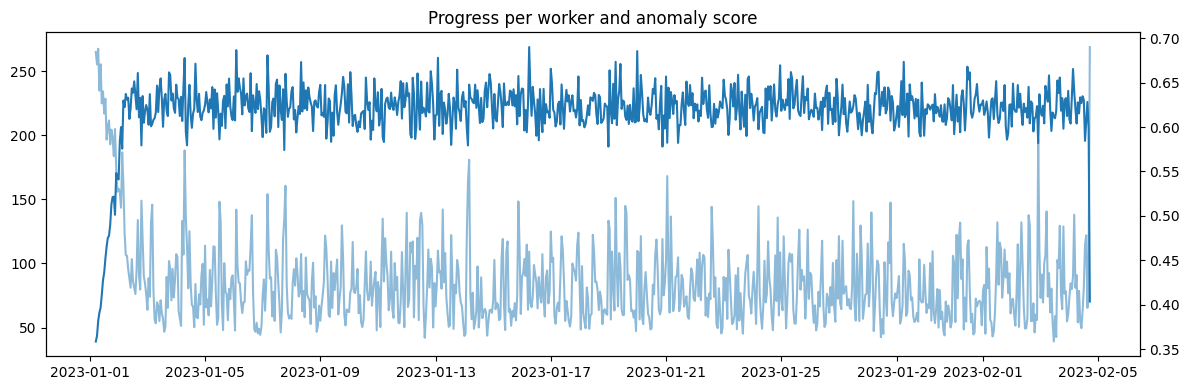

<Figure size 640x480 with 0 Axes>

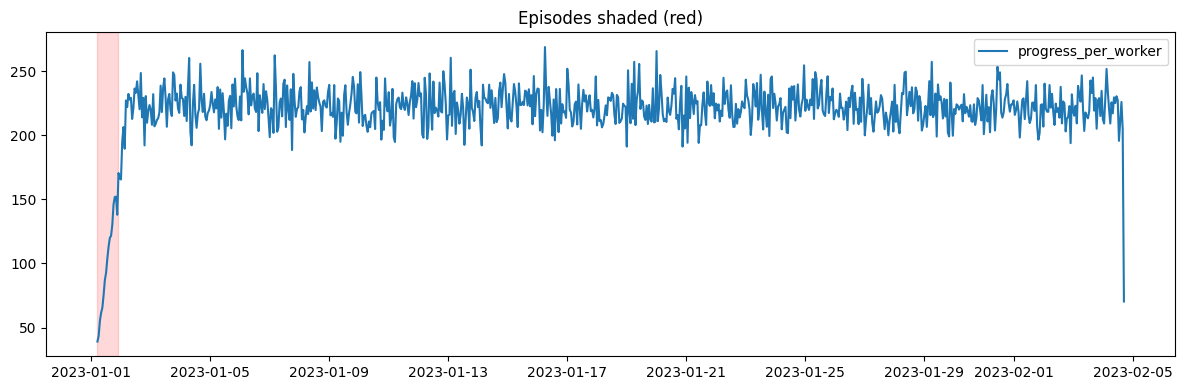

<Figure size 640x480 with 0 Axes>

In [59]:
plt.figure(figsize=(12,4))
plt.plot(scores["timestamp"], feats["progress_per_worker"].iloc[scores.index], label="progress_per_worker")
plt.twinx()
plt.plot(scores["timestamp"], scores["anomaly_score"], alpha=0.5, label="anomaly_score")
plt.title("Progress per worker and anomaly score")
plt.tight_layout()
plt.show()
plt.savefig("progress_anomaly.png")


fig, ax = plt.subplots(figsize=(12,4))
ax.plot(feats["timestamp"], feats["progress_per_worker"], label="progress_per_worker")
for _, row in episodes.iterrows():
    ax.axvspan(pd.to_datetime(row["start"]), pd.to_datetime(row["end"]), color="red", alpha=0.15)
ax.set_title("Episodes shaded (red)")
ax.legend()
plt.tight_layout()
plt.show()
plt.savefig("progress_episodes.png")

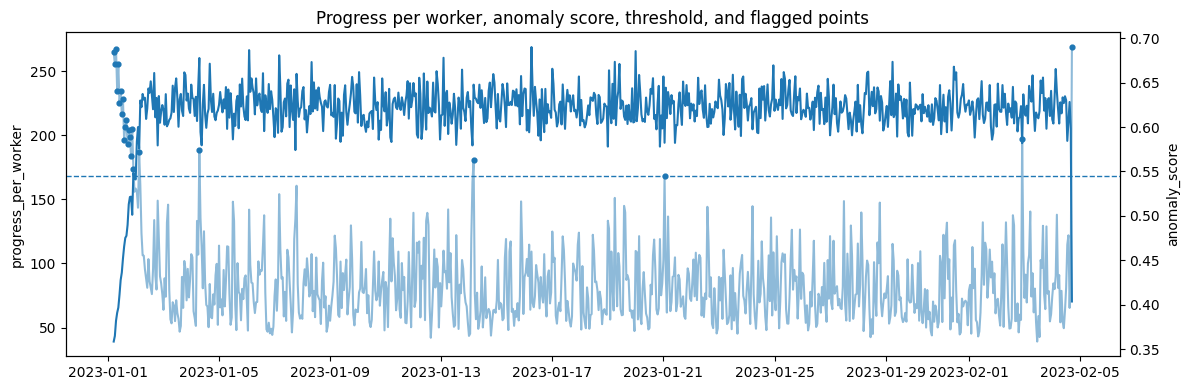

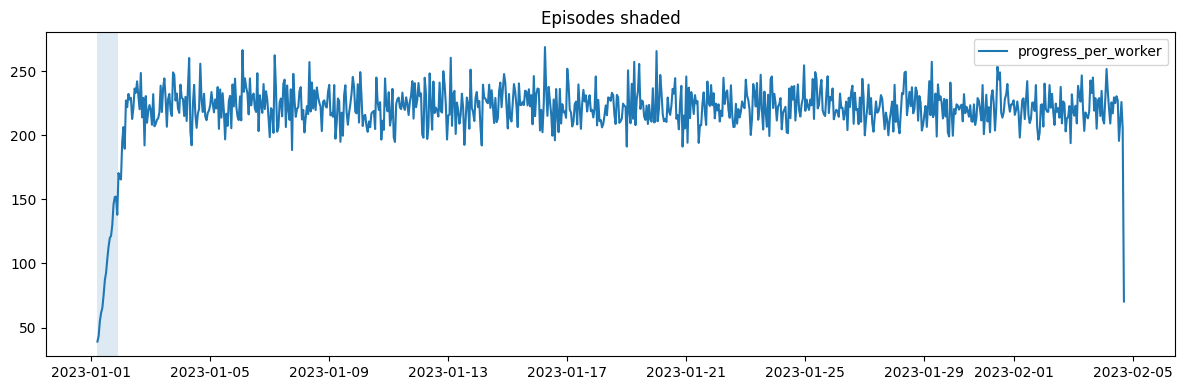

In [60]:
"""Recompute threshold and overlay anomalies + episodes"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Threshold for top CONTAM fraction
k = max(1, int(len(scores) * CONTAM))
thr = np.partition(scores["anomaly_score"].values, -k)[-k]

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(scores["timestamp"], feats["progress_per_worker"].iloc[scores.index], label="progress_per_worker")
ax1.set_ylabel("progress_per_worker")


ax2 = ax1.twinx()
ax2.plot(scores["timestamp"], scores["anomaly_score"], alpha=0.5, label="anomaly_score")
ax2.axhline(thr, linestyle="--", linewidth=1, label="threshold")
ax2.set_ylabel("anomaly_score")

anom = scores[scores["is_anomaly"] == 1]
ax2.scatter(anom["timestamp"], anom["anomaly_score"], s=12)

ax1.set_title("Progress per worker, anomaly score, threshold, and flagged points")
fig.tight_layout()
plt.show()

if "episodes" in globals() and isinstance(episodes, pd.DataFrame) and not episodes.empty:
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(feats["timestamp"], feats["progress_per_worker"], label="progress_per_worker")
    for _, row in episodes.iterrows():
        ax.axvspan(pd.to_datetime(row["start"]), pd.to_datetime(row["end"]), alpha=0.15)
    ax.set_title("Episodes shaded")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [61]:
feats = feats.sort_values("timestamp").reset_index(drop=True)

feats["util_delta"] = feats["equipment_utilization_rate"].diff()

PROGRESS_FLAT_EPS = float(feats["task_progress"].quantile(0.10))
UTIL_DROP_THRESHOLD = -8.0

feats["progress_flat"] = feats["task_progress"].abs() <= PROGRESS_FLAT_EPS
feats["rule_drift"] = (feats["util_delta"] <= UTIL_DROP_THRESHOLD) & feats["progress_flat"]

scores2 = scores.merge(
    feats[["timestamp", "rule_drift", "util_delta", "task_progress", "equipment_utilization_rate",
           "energy_consumption", "worker_count", "material_usage"]],
    on="timestamp",
    how="left"
)

scores2["is_anomaly_final"] = ((scores2["is_anomaly"] == 1) | (scores2["rule_drift"] == True)).astype(int)
scores2[["timestamp","is_anomaly","rule_drift","is_anomaly_final"]].head(10)


,timestamp,is_anomaly,rule_drift,is_anomaly_final
0,2023-01-01 05:00:00,1,False,1
1,2023-01-01 06:00:00,1,False,1
2,2023-01-01 07:00:00,1,False,1
3,2023-01-01 08:00:00,1,False,1
4,2023-01-01 09:00:00,1,False,1
5,2023-01-01 10:00:00,1,False,1
6,2023-01-01 11:00:00,1,False,1
7,2023-01-01 12:00:00,1,False,1
8,2023-01-01 13:00:00,1,False,1
9,2023-01-01 14:00:00,1,False,1


In [62]:
tmp = scores2.copy()
tmp["is_anomaly"] = tmp["is_anomaly_final"]

episodes = to_episodes(tmp, min_len=2, merge_gap=1)
episodes.head(10)


,start,end,peak_score,mean_score,length
0,2023-01-01 05:00:00,2023-01-01 22:00:00,0.688232,0.619286,18


In [63]:
episode_rows = []

for idx, row in episodes.iterrows():
    start = row["start"]
    end = row["end"]

    window = scores2[(scores2["timestamp"] >= start) & (scores2["timestamp"] <= end)].copy()
    if window.empty:
        continue

    duration_hours = (window["timestamp"].max() - window["timestamp"].min()).total_seconds() / 3600.0

    mean_util_delta = window["util_delta"].mean()
    max_anomaly_score = window["anomaly_score"].max()

    energy_per_worker = (window["energy_consumption"] / (window["worker_count"].clip(lower=1))).mean() \
        if "energy_consumption" in window.columns and "worker_count" in window.columns else np.nan

    mean_progress = window["task_progress"].mean() if "task_progress" in window.columns else np.nan


    util_drop_mag = max(0.0, -float(mean_util_delta)) if pd.notna(mean_util_delta) else 0.0

    impact_score = (
        0.4 * (duration_hours if pd.notna(duration_hours) else 0.0)
        + 0.4 * util_drop_mag
        + 0.2 * (float(max_anomaly_score) if pd.notna(max_anomaly_score) else 0.0)
    )

    episode_rows.append({
        "episode_id": int(idx),
        "start": start,
        "end": end,
        "duration_hours": float(duration_hours),
        "mean_util_delta": None if pd.isna(mean_util_delta) else float(mean_util_delta),
        "max_anomaly_score": None if pd.isna(max_anomaly_score) else float(max_anomaly_score),
        "mean_energy_per_worker": None if pd.isna(energy_per_worker) else float(energy_per_worker),
        "mean_task_progress": None if pd.isna(mean_progress) else float(mean_progress),
        "impact_score": float(impact_score),
    })

episode_table = pd.DataFrame(episode_rows).sort_values("impact_score", ascending=False).reset_index(drop=True)
episode_table.head(10)


,episode_id,start,end,duration_hours,mean_util_delta,max_anomaly_score,mean_energy_per_worker,mean_task_progress,impact_score
0,0,2023-01-01 05:00:00,2023-01-01 22:00:00,17.0,0.006395,0.688232,602.212068,2818.96019,6.937646


In [64]:
import json

def severity_from_impact(s: float) -> str:
    if s >= 20: return "High"
    if s >= 10: return "Medium"
    return "Low"

alerts = []
for _, r in episode_table.iterrows():
    alerts.append({
        "module": "Utilization & Progress Drift",
        "episode_id": int(r["episode_id"]),
        "start_time": str(r["start"]),
        "end_time": str(r["end"]),
        "duration_hours": float(r["duration_hours"]),
        "severity": severity_from_impact(float(r["impact_score"])),
        "impact_score": float(r["impact_score"]),
        "signals": {
            "mean_util_delta": r["mean_util_delta"],
            "max_anomaly_score": r["max_anomaly_score"],
            "mean_energy_per_worker": r["mean_energy_per_worker"],
            "mean_task_progress": r["mean_task_progress"],
        },
        "reason": "Utilization drop with flat progress and/or multivariate anomaly spike.",
        "recommended_action": "Check equipment downtime, crew allocation, material availability, and reporting accuracy."
    })

with open("task3_alerts.json", "w") as f:
    json.dump(alerts, f, indent=2)

episode_table.to_csv("task3_drift_episodes.csv", index=False)

print("task3_alerts.json")
print("task3_drift_episodes.csv")
print("Example alert:\n", json.dumps(alerts[0], indent=2) if alerts else "No alerts")


task3_alerts.json
task3_drift_episodes.csv
Example alert:
 {
  "module": "Utilization & Progress Drift",
  "episode_id": 0,
  "start_time": "2023-01-01 05:00:00",
  "end_time": "2023-01-01 22:00:00",
  "duration_hours": 17.0,
  "severity": "Low",
  "impact_score": 6.937646454064386,
  "signals": {
    "mean_util_delta": 0.0063954522797941725,
    "max_anomaly_score": 0.6882322703219255,
    "mean_energy_per_worker": 602.212067889915,
    "mean_task_progress": 2818.9601904478936
  },
  "reason": "Utilization drop with flat progress and/or multivariate anomaly spike.",
  "recommended_action": "Check equipment downtime, crew allocation, material availability, and reporting accuracy."
}
